In [1]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import plotly.express as px
import plotly.graph_objects as go
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, log_loss, roc_curve, roc_auc_score, f1_score, precision_score, recall_score
import optuna
import shap


## Carregar os dados

In [2]:
# Carregar o dataset
df_employee = pd.read_csv('./employee_churn.csv', parse_dates=['data_contratacao','data_demissao','data_ultimo_feedback',
                                                               'data_ultimo_aumento','data_ultima_mudanca_cargo'],
                                                    date_format='%Y-%m-%d')

In [3]:
df_employee.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   id                         2000 non-null   object        
 1   idade                      2000 non-null   int64         
 2   genero                     2000 non-null   object        
 3   estado_civil               2000 non-null   object        
 4   educacao                   2000 non-null   object        
 5   regime_trabalho            2000 non-null   object        
 6   data_contratacao           2000 non-null   datetime64[ns]
 7   data_demissao              286 non-null    datetime64[ns]
 8   tipo_demissao              286 non-null    object        
 9   cargo                      2000 non-null   object        
 10  salario_atual              2000 non-null   int64         
 11  data_ultimo_feedback       2000 non-null   datetime64[ns]
 12  data_u

In [4]:
df_employee.head()

,id,idade,genero,estado_civil,educacao,regime_trabalho,data_contratacao,data_demissao,tipo_demissao,cargo,salario_atual,data_ultimo_feedback,data_ultimo_aumento,data_ultima_mudanca_cargo,nota_avaliacao,acompanhamento_psicologo,qtde_projetos,qtde_clientes,nivel_satisfacao_gestor,churn
0,EMP1564,37,F,Divorciado(a),Master,Remoto,2020-01-02,NaT,NaN,Senior Developer,10207,2024-05-09,2023-07-31,2022-11-03,9.6,True,5,1,7.0,0
1,EMP0959,45,Outro,Divorciado(a),Master,Remoto,2020-01-03,NaT,NaN,UX Designer,23921,2024-04-05,2023-09-10,2022-02-11,8.4,True,8,4,9.1,0
2,EMP0494,54,M,Viúvo(a),Technical Degree,Híbrido,2020-01-04,NaT,NaN,Tech Lead,15298,2023-06-16,2021-12-26,2021-05-10,8.5,False,9,7,1.3,0
3,EMP1231,44,M,Casado(a),Bachelor,Remoto,2020-01-05,NaT,NaN,QA Engineer,15306,2021-12-04,2022-01-01,2024-08-30,7.9,False,8,4,8.4,0
4,EMP1912,53,Outro,Viúvo(a),PhD,Presencial,2020-01-07,NaT,NaN,Senior Developer,17723,2022-03-04,2023-11-18,2024-08-08,7.5,True,5,2,8.2,0


## Engenharia de Features

In [5]:
# Criar features baseadas em datas (diferença em dias)

# Calcular o tempo de empresa

df_employee['tempo_empresa'] = df_employee.apply(lambda x : (pd.Timestamp.now() - x['data_contratacao']).days if x['churn'] == 0
                                                 else (x['data_demissao'] - x['data_contratacao']).days, axis=1)

# Calcular tempo desde o útlimo feedback
df_employee['dias_desde_ultimo_feedback'] = (pd.Timestamp.now() - df_employee['data_ultimo_feedback']).dt.days

# Calcular tempo desde o útlimo aumento
df_employee['dias_desde_ultimo_aumento'] = (pd.Timestamp.now() - df_employee['data_ultimo_aumento']).dt.days

# Calcular tempo desde a útlima mudança de cargo
df_employee['dias_desde_ultima_mudanca_cargo'] = (pd.Timestamp.now() - df_employee['data_ultima_mudanca_cargo']).dt.days

In [6]:
df_employee.tail(20)

,id,idade,genero,estado_civil,educacao,regime_trabalho,data_contratacao,data_demissao,tipo_demissao,cargo,...,nota_avaliacao,acompanhamento_psicologo,qtde_projetos,qtde_clientes,nivel_satisfacao_gestor,churn,tempo_empresa,dias_desde_ultimo_feedback,dias_desde_ultimo_aumento,dias_desde_ultima_mudanca_cargo
1980,EMP1745,40,M,Casado(a),Technical Degree,Presencial,2024-07-08,NaT,NaN,UX Designer,...,6.5,False,5,4,1.3,0,563,482,536,562
1981,EMP0323,46,Outro,Divorciado(a),Technical Degree,Híbrido,2024-07-09,NaT,NaN,Tech Lead,...,8.4,True,9,1,3.2,0,562,525,467,519
1982,EMP0047,26,M,Solteiro(a),Master,Presencial,2024-07-10,NaT,NaN,Data Scientist,...,9.3,True,7,1,6.3,0,561,522,531,554
1983,EMP0063,24,Outro,Divorciado(a),Bachelor,Remoto,2024-07-11,NaT,NaN,Tech Lead,...,7.4,False,5,6,2.1,0,560,508,536,548
1984,EMP1864,46,M,Casado(a),Technical Degree,Presencial,2024-07-12,NaT,NaN,Senior Developer,...,6.1,True,6,1,7.6,0,559,537,526,459
1985,EMP1333,39,Outro,Divorciado(a),Bachelor,Remoto,2024-07-12,2024-09-20,Voluntária,Tech Lead,...,9.9,True,8,1,9.6,1,70,505,538,559
1986,EMP0071,24,Outro,Divorciado(a),Technical Degree,Híbrido,2024-07-12,2024-10-20,Voluntária,UX Designer,...,9.9,False,6,6,3.3,1,100,547,553,476
1987,EMP1740,39,M,Casado(a),Master,Híbrido,2024-07-12,NaT,NaN,Tech Lead,...,6.8,True,3,1,7.5,0,559,536,481,530
1988,EMP1858,44,M,Casado(a),Technical Degree,Híbrido,2024-07-14,NaT,NaN,Tech Lead,...,9.7,False,8,7,9.5,0,557,463,478,554
1989,EMP0688,26,F,Solteiro(a),PhD,Híbrido,2024-07-15,NaT,NaN,QA Engineer,...,8.5,True,3,7,2.1,0,556,472,503,478


In [7]:
df_employee.drop(columns=['id'],axis=1,inplace=True)

## EDA

In [8]:
print("Valores ausentes por coluna:")
df_employee.isnull().sum()

Valores ausentes por coluna:


idade                                 0
genero                                0
estado_civil                          0
educacao                              0
regime_trabalho                       0
data_contratacao                      0
data_demissao                      1714
tipo_demissao                      1714
cargo                                 0
salario_atual                         0
data_ultimo_feedback                  0
data_ultimo_aumento                   0
data_ultima_mudanca_cargo             0
nota_avaliacao                        0
acompanhamento_psicologo              0
qtde_projetos                         0
qtde_clientes                         0
nivel_satisfacao_gestor               0
churn                                 0
tempo_empresa                         0
dias_desde_ultimo_feedback            0
dias_desde_ultimo_aumento             0
dias_desde_ultima_mudanca_cargo       0
dtype: int64

In [9]:
# Distribuição da variável target em percentual
contagem = df_employee['churn'].value_counts()/len(df_employee) * 100
fig = px.bar(contagem, title='Fator de Churn', color=contagem.index, opacity=0.8)

fig.update_layout(showlegend=False)
fig.show()

In [10]:
# Valores possíveis para variáveis categóricas

for col in df_employee.select_dtypes(include=['object']).columns:
    print(f'coluna: {col}: \n{df_employee[col].unique()}')

coluna: genero: 
['F' 'Outro' 'M']
coluna: estado_civil: 
['Divorciado(a)' 'Viúvo(a)' 'Casado(a)' 'Solteiro(a)']
coluna: educacao: 
['Master' 'Technical Degree' 'Bachelor' 'PhD']
coluna: regime_trabalho: 
['Remoto' 'Híbrido' 'Presencial']
coluna: tipo_demissao: 
[nan 'Involuntária' 'Voluntária']
coluna: cargo: 
['Senior Developer' 'UX Designer' 'Tech Lead' 'QA Engineer'
 'Junior Developer' 'Product Manager' 'DevOps Engineer' 'Data Scientist']


In [11]:
# Estatisticas descritivas das variáveis numéricas
df_employee.select_dtypes(include=['int64','float64']).describe()

,idade,salario_atual,nota_avaliacao,qtde_projetos,qtde_clientes,nivel_satisfacao_gestor,churn,tempo_empresa,dias_desde_ultimo_feedback,dias_desde_ultimo_aumento,dias_desde_ultima_mudanca_cargo
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.00000,2000.0000,2000.00000,2000.000000,2000.000000
mean,37.938500,14801.834500,7.997550,4.984500,3.998500,5.492450,0.14300,1250.1970,942.89900,956.005000,943.136500
std,9.456132,5763.451836,1.157324,2.593188,1.987076,2.609817,0.35016,556.6744,395.59628,397.623967,395.911115
min,22.000000,5016.000000,6.000000,1.000000,1.000000,1.000000,0.00000,34.0000,456.00000,457.000000,456.000000
25%,30.000000,9844.250000,7.000000,3.000000,2.000000,3.300000,0.00000,824.7500,612.75000,618.750000,616.750000
50%,38.000000,14822.500000,8.000000,5.000000,4.000000,5.500000,0.00000,1264.5000,841.50000,856.000000,833.000000
75%,46.000000,19702.500000,9.000000,7.000000,6.000000,7.700000,0.00000,1721.5000,1182.25000,1215.250000,1176.000000
max,54.000000,24988.000000,10.000000,9.000000,7.000000,10.000000,1.00000,2212.0000,2175.00000,2128.000000,2168.000000


In [12]:
# Boxplots para variáveis numéricas com Churn
for col in df_employee.select_dtypes(include=['int64','float64']).columns:
    if col != 'churn':
        fig = px.box(df_employee, x='churn',y=col, title=f'Boxplot de {col} vs Churn', color='churn')
        fig.show()

In [13]:
# Matriz de correlação

colunas_numericas =df_employee.select_dtypes(include=['int64','float64']).columns
corr_matrix = df_employee[colunas_numericas].corr()

fig = px.imshow(corr_matrix,
                title='Matriz de Correlação',
                color_continuous_scale='Viridis',
                zmin=-1,
                zmax=1)

fig.update_traces(
    text=corr_matrix, texttemplate='%{text:.1%}', textfont={'size': 9}
)

fig.update_layout(
    width=1000,
    height=600,
    title_font=dict(size=14),
    font=dict(size=10)
)

fig.show()


In [14]:
# Matriz de dispersão

fig = px.scatter_matrix(df_employee, dimensions=colunas_numericas,
                        color='churn', title='Matriz de Dispersão')

fig.update_layout(
    width=1200,
    height=1000,
    title_font=dict(size=14),
    font=dict(size=9)
)

fig.show()

In [15]:
# Teste de hipóteses para variáveis caregóricas x churn

colunas_categoricas =df_employee.select_dtypes(include=['object']).columns

for col in colunas_categoricas:
    contingency_table = pd.crosstab(df_employee['churn'],df_employee[col])
    chi2,p_value, dof, expected = chi2_contingency(contingency_table)

    print(f'\nTeste de Chi-quadrado para {col} x Churn')
    print(f'p-valor: {p_value}')

    if p_value <= 0.05:
        print(f'As variáveis {col} e Churn não são independentes')
    else:
        print(f'As variáveis {col} e Churn são independentes')


Teste de Chi-quadrado para genero x Churn
p-valor: 0.6391382063144609
As variáveis genero e Churn são independentes

Teste de Chi-quadrado para estado_civil x Churn
p-valor: 0.8332629331272039
As variáveis estado_civil e Churn são independentes

Teste de Chi-quadrado para educacao x Churn
p-valor: 0.20475149121388256
As variáveis educacao e Churn são independentes

Teste de Chi-quadrado para regime_trabalho x Churn
p-valor: 0.9751275918764937
As variáveis regime_trabalho e Churn são independentes

Teste de Chi-quadrado para tipo_demissao x Churn
p-valor: 1.0
As variáveis tipo_demissao e Churn são independentes

Teste de Chi-quadrado para cargo x Churn
p-valor: 0.4586024122014404
As variáveis cargo e Churn são independentes


In [16]:
# Gráficos de barras para variáveis categoricas x churn
for col in colunas_categoricas:
    fig = px.histogram(df_employee, x=col, color='churn', barmode='group',title=f'Distribuição de {col} por Churn')

    fig.show()


## Preparação dos dados

In [17]:
# Separar features e target

# Criar lista de colunas do tipo datetime
colunas_data = list(df_employee.select_dtypes(include=['datetime64']).columns)

# X e y

X = df_employee.drop(columns=['churn','tipo_demissao'] + colunas_data, axis=1)
y = df_employee['churn']


In [18]:
# Criar um preprocessador

# Lista de colunas por tipo
feature_numericas = X.select_dtypes(include=['int64', 'float64']).columns
feature_categoricas = X.select_dtypes(include=['object']).columns

# Preprocessador
preprocessador = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(),feature_numericas),
        ('cat', OneHotEncoder(handle_unknown='ignore'), feature_categoricas)
    ]
)

In [19]:
# Dividir os dados entre Treino e Teste
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.5,random_state=42)

# Aplicar o Column Transformer
X_train = preprocessador.fit_transform(X_train)
X_test = preprocessador.transform(X_test)

In [20]:
print(X_train.shape)
print(X_test.shape)

(1000, 32)
(1000, 32)


## Treinamento do Modelo - Baseline

In [21]:
# Criar o modelo de RandomForest

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=51,
    max_features='sqrt',
    class_weight='balanced'
)

In [22]:
# Treinar o modelo
rf_model.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",20
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(y

## Análise dos Resultados Baseline

In [23]:
# Fazer predições (classificações - 0 ou 1)
y_pred = rf_model.predict(X_test)

In [24]:
y_pred

array([1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,

In [25]:
# Retornar as probabilidades das previsões
y_pred_proba = rf_model.predict_proba(X_test)

In [26]:
# Mostrar probabilidadees
y_pred_proba

array([[0.49, 0.51],
       [0.89, 0.11],
       [0.98, 0.02],
       ...,
       [0.98, 0.02],
       [0.98, 0.02],
       [0.95, 0.05]], shape=(1000, 2))

In [27]:
print(classification_report(y_test,y_pred)) 

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       849
           1       1.00      0.69      0.82       151

    accuracy                           0.95      1000
   macro avg       0.97      0.84      0.89      1000
weighted avg       0.96      0.95      0.95      1000



In [28]:
# Retornar os valores da curva ROC - TPR vs FPR e Threshold (Pontos de Corte)
# y_pred_proba[:, 1] todas as informações apenas do churn
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1])

In [29]:
# Calcular AUC (Area Under the Curve)
roc_auc = roc_auc_score(y_test, y_pred_proba[:,1])

In [30]:
# Plotar a Curva ROC 
fig = px.area(
    x=fpr,
    y=tpr,
    title=f'ROC Curve (AUC={roc_auc:.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700,
    height=500
)

fig.add_shape(
    type='line',
    line=dict(dash='dash'),
    x0=0,x1=1,y0=0,y1=1
)

fig.update_yaxes(scaleanchor='x',scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

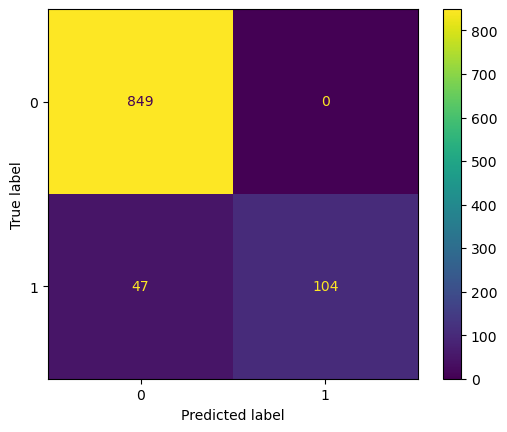

In [31]:
# Mostrar a matriz de confusão

conf_matrix = confusion_matrix(y_test, y_pred)
fig = ConfusionMatrixDisplay(conf_matrix)
fig.plot()

In [32]:
# calcular log loss
print(f'Log loss: {log_loss(y_test,y_pred_proba):.4f}')

Log loss: 0.1542


## Treinar modelo com Validação cruzada e tuning de hiperparâmetros

In [33]:
# Criar um dicionario com os valores dos hiperparâmetros a serem testados

param_grid = {
    'n_estimators': [50,100,200],
    'max_depth': [None, 10,20,30],
    'min_samples_split': [2,5,10,20],
    'min_samples_leaf': [1,2,5,10]
}

In [34]:
# Configurar o GridSearchCV com 5 folds (com StratifiedKFold) e usando Recall como métrica de validação

rf_model_cv = RandomForestClassifier(class_weight='balanced',random_state=51, max_features='sqrt')
kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=51)
grid_search = GridSearchCV(rf_model_cv, param_grid=param_grid,cv=kfolds, scoring='recall', verbose=2)


In [35]:
# Treinar o modelo usando cross-validation para buscar melhores hiperparâmetros
grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 192 candidates, totalling 960 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_de

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",RandomForestC...ndom_state=51)
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'max_depth': [None, 10, ...], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 5, ...], 'n_estimators': [50, 100, ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'recall'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",StratifiedKFo... shuffle=True)
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the com

### Usando o conceito de cross validation, nós trabalhamos na verdade com conjunto de treino + val + teste
### X_train (50%) -> cross_validade -> 4 partições pra treino + 1 validação
### Gera o melhor modelo e validamos com X_test (50%)

## Análise de resultado - GridSearchCV

In [36]:
# Retornar o melhor modelo

best_model = grid_search.best_estimator_

In [37]:
best_params = grid_search.best_estimator_
best_params

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",200
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",20
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",2
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metri

In [38]:
best_score = grid_search.best_score_
best_score

np.float64(0.8444444444444444)

In [39]:
# Fazer predições (classificações - 0 ou 1)
y_pred = best_model.predict(X_test)

In [40]:
y_pred

array([1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,

In [41]:
# Retornar as probabilidades das previsões
y_pred_proba = best_model.predict_proba(X_test)

In [42]:
# Mostrar probabilidadees
y_pred_proba

array([[0.38292608, 0.61707392],
       [0.79678343, 0.20321657],
       [0.94649323, 0.05350677],
       ...,
       [0.93839018, 0.06160982],
       [0.92837005, 0.07162995],
       [0.94580204, 0.05419796]], shape=(1000, 2))

In [ ]:
print(classification_report(y_test,y_pred)) 

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       849
           1       1.00      0.80      0.89       151

    accuracy                           0.97      1000
   macro avg       0.98      0.90      0.94      1000
weighted avg       0.97      0.97      0.97      1000



In [44]:
# Retornar os valores da curva ROC - TPR vs FPR e Threshold (Pontos de Corte)
# y_pred_proba[:, 1] todas as informações apenas do churn
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1])

In [45]:
# Calcular AUC (Area Under the Curve)
roc_auc = roc_auc_score(y_test, y_pred_proba[:,1])

In [46]:
# Plotar a Curva ROC 
fig = px.area(
    x=fpr,
    y=tpr,
    title=f'ROC Curve (AUC={roc_auc:.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700,
    height=500
)

fig.add_shape(
    type='line',
    line=dict(dash='dash'),
    x0=0,x1=1,y0=0,y1=1
)

fig.update_yaxes(scaleanchor='x',scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

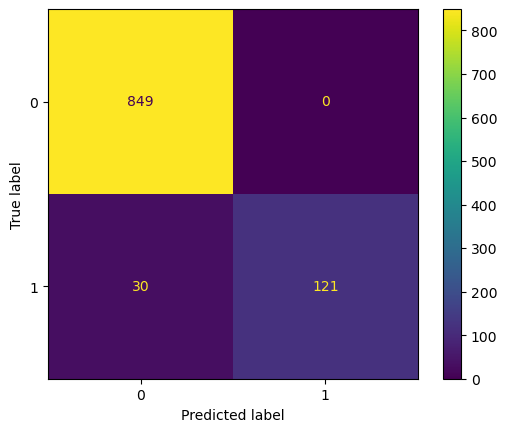

In [47]:
# Mostrar a matriz de confusão

conf_matrix = confusion_matrix(y_test, y_pred)
fig = ConfusionMatrixDisplay(conf_matrix)
fig.plot()

In [48]:
# calcular log loss
print(f'Log loss: {log_loss(y_test,y_pred_proba):.4f}')

Log loss: 0.1981


## Ajustar Threshold

In [49]:
# Criar uma lista de thresholds para testar
thresholds = [0.3,0.4,0.5,0.6,0.7]

# Lista para armazenar métrica
recalls = []

# Calcular as métricas para cada threshold

for threshold in thresholds:
    # Fazer predições com o threshold
    y_pred_threshold = (y_pred_proba[:,1] >= threshold).astype(int)
    recall = recall_score(y_test,y_pred_threshold)

    # Inserir métrica na lista
    recalls.append(recall)


In [50]:
# Criar DataFrame

df_result = pd.DataFrame({'Threshold': thresholds, 'Recall': recalls})

In [51]:
melhor_threshold = df_result.loc[df_result['Recall'].idxmax()]

print(f'Maior Threshold : {melhor_threshold['Threshold']}')
print(f'Maior Recall : {melhor_threshold['Recall']:.4f}')

Maior Threshold : 0.3
Maior Recall : 0.9139


In [52]:
# Plotar um gráfico com Threshold
fig = go.Figure()

fig.add_trace(
    go.Scatter(x=thresholds, y=recalls, name='Recall', line=dict(color='blue'))
)

fig.update_layout(
    title='Recall por Threshold',
    xaxis_title='Recall Score',
    yaxis_title='Threshold',
    width=800,
    height=500
)

## Análise de métricas com o threshold

In [53]:
# Fazer predições
y_pred = (y_pred_proba[:,1] >= melhor_threshold['Threshold']).astype(int)

In [54]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       849
           1       0.90      0.91      0.91       151

    accuracy                           0.97      1000
   macro avg       0.94      0.95      0.95      1000
weighted avg       0.97      0.97      0.97      1000



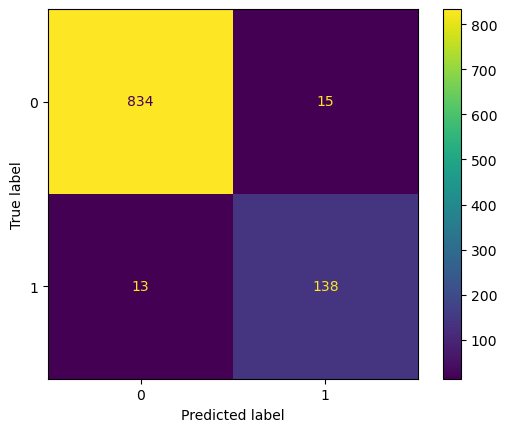

In [55]:
# Mostrar a matriz de confusão

conf_matrix = confusion_matrix(y_test, y_pred)
fig = ConfusionMatrixDisplay(conf_matrix)
fig.plot()

In [56]:
# calcular log loss
print(f'Log loss: {log_loss(y_test,y_pred_proba):.4f}')

Log loss: 0.1981


## Interpretabilidade

In [57]:
# Importância das variáveis

importances = best_model.feature_importances_
nomes_features = preprocessador.get_feature_names_out()

# Criar um DataFrame com as importâncias e nomes da features
df_importancias = pd.DataFrame({'feature': nomes_features, 'importancia': importances})

df_importancias = df_importancias.sort_values(by='importancia', ascending=True).reset_index(drop=True)

In [58]:
df_importancias.head()

,feature,importancia
0,cat__estado_civil_Solteiro(a),0.002090
1,cat__cargo_QA Engineer,0.002198
2,cat__genero_M,0.002471
3,cat__educacao_Bachelor,0.002540
4,cat__cargo_Product Manager,0.002621


In [59]:
# Criar um gráfico com as importâncias

fig = px.bar(
    df_importancias.head(10),
    x='importancia',
    y='feature',
    orientation='h',
    title='Importâncias das 10 principais features',
    labels={'importancia': 'Importância', 'feature': 'Feature'},
    color='importancia',
    color_continuous_scale='Viridis'
)

fig.update_layout(
    height=600,
    yaxis={'categoryorder': 'total ascending'}
)

fig.show()

In [60]:
# Visualizar as Árvores da Random Forest

# Função para visualizar árvore

def visualizar_arvore(modelo, indice_arvore, max_profundidade=5):
    plt.figure(figsize=(20,10))
    plot_tree(modelo.estimators_[indice_arvore],
              feature_names=nomes_features,
              class_names=['0','1'],
              filled=True,
              rounded=True,
              max_depth=max_profundidade,
              fontsize=9,
              proportion=True,
              precision=2)
    plt.title(f'Árvore {indice_arvore} da Random Forest', fontsize=14)
    plt.tight_layout()
    plt.show()


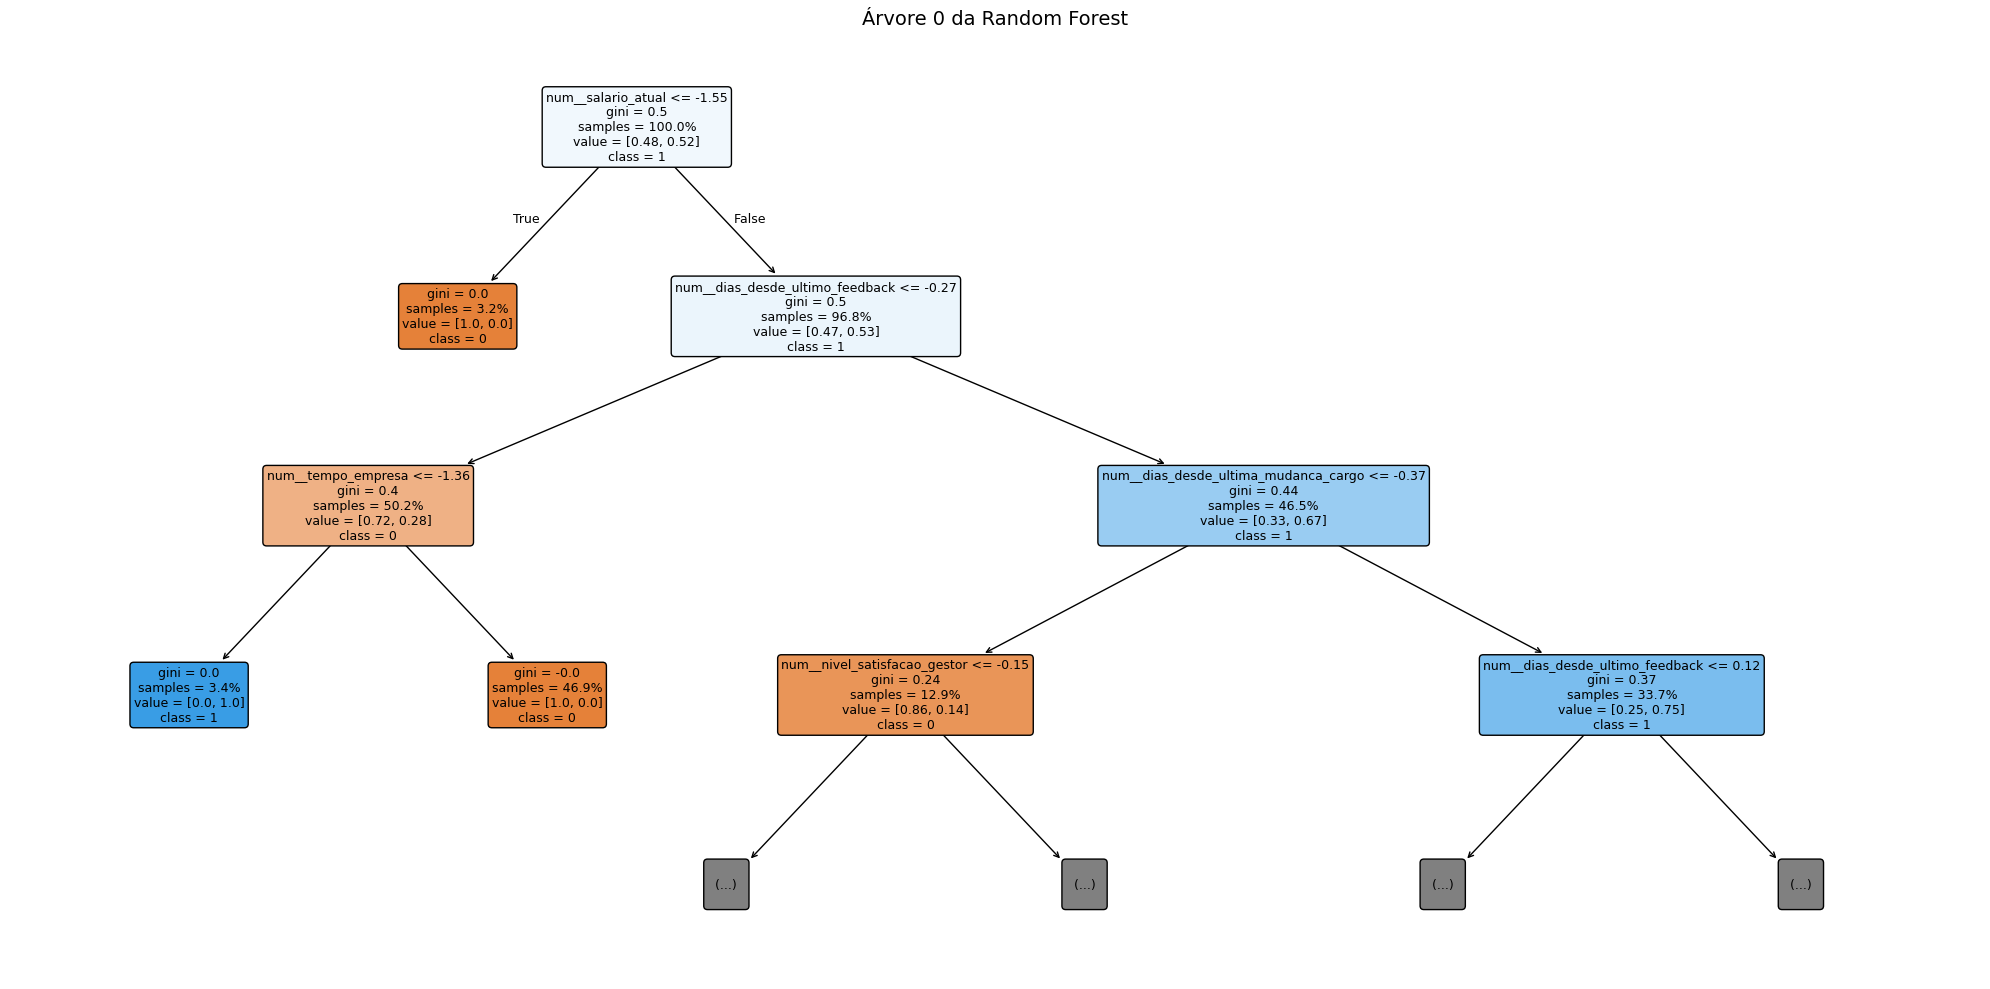

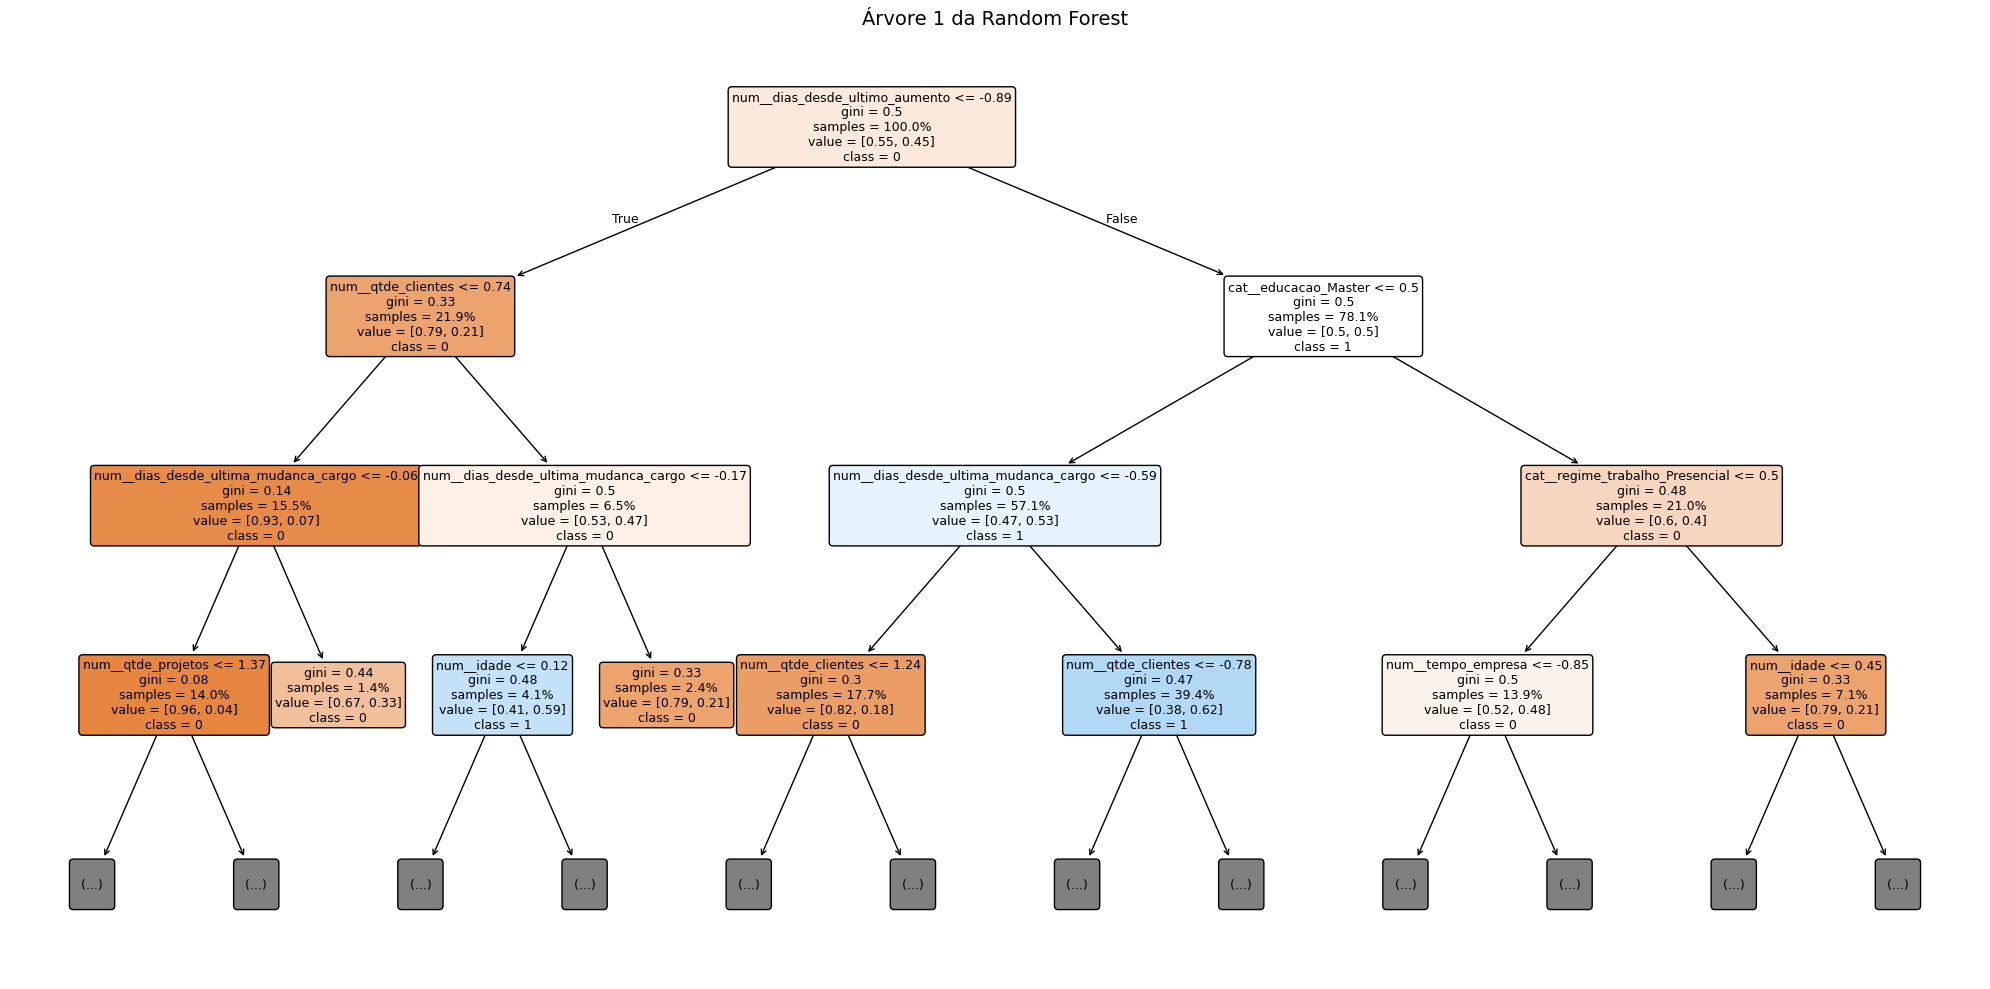

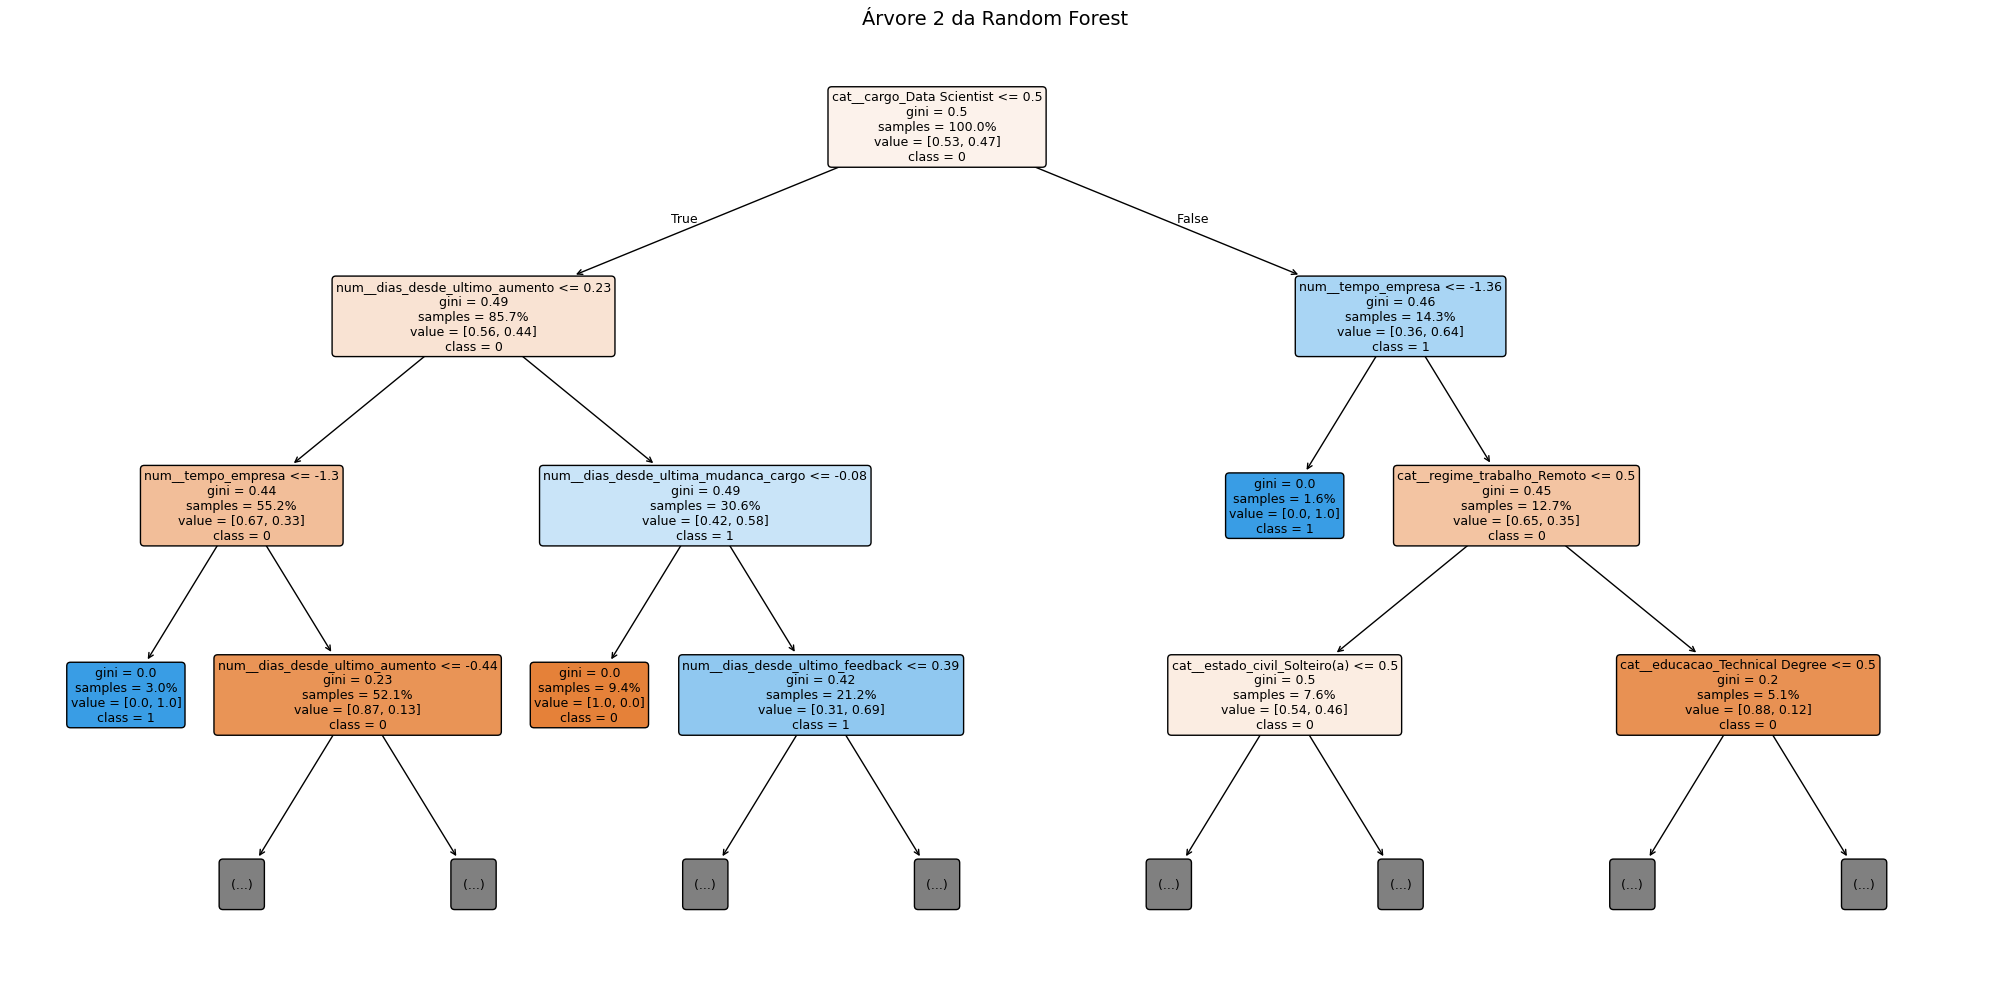

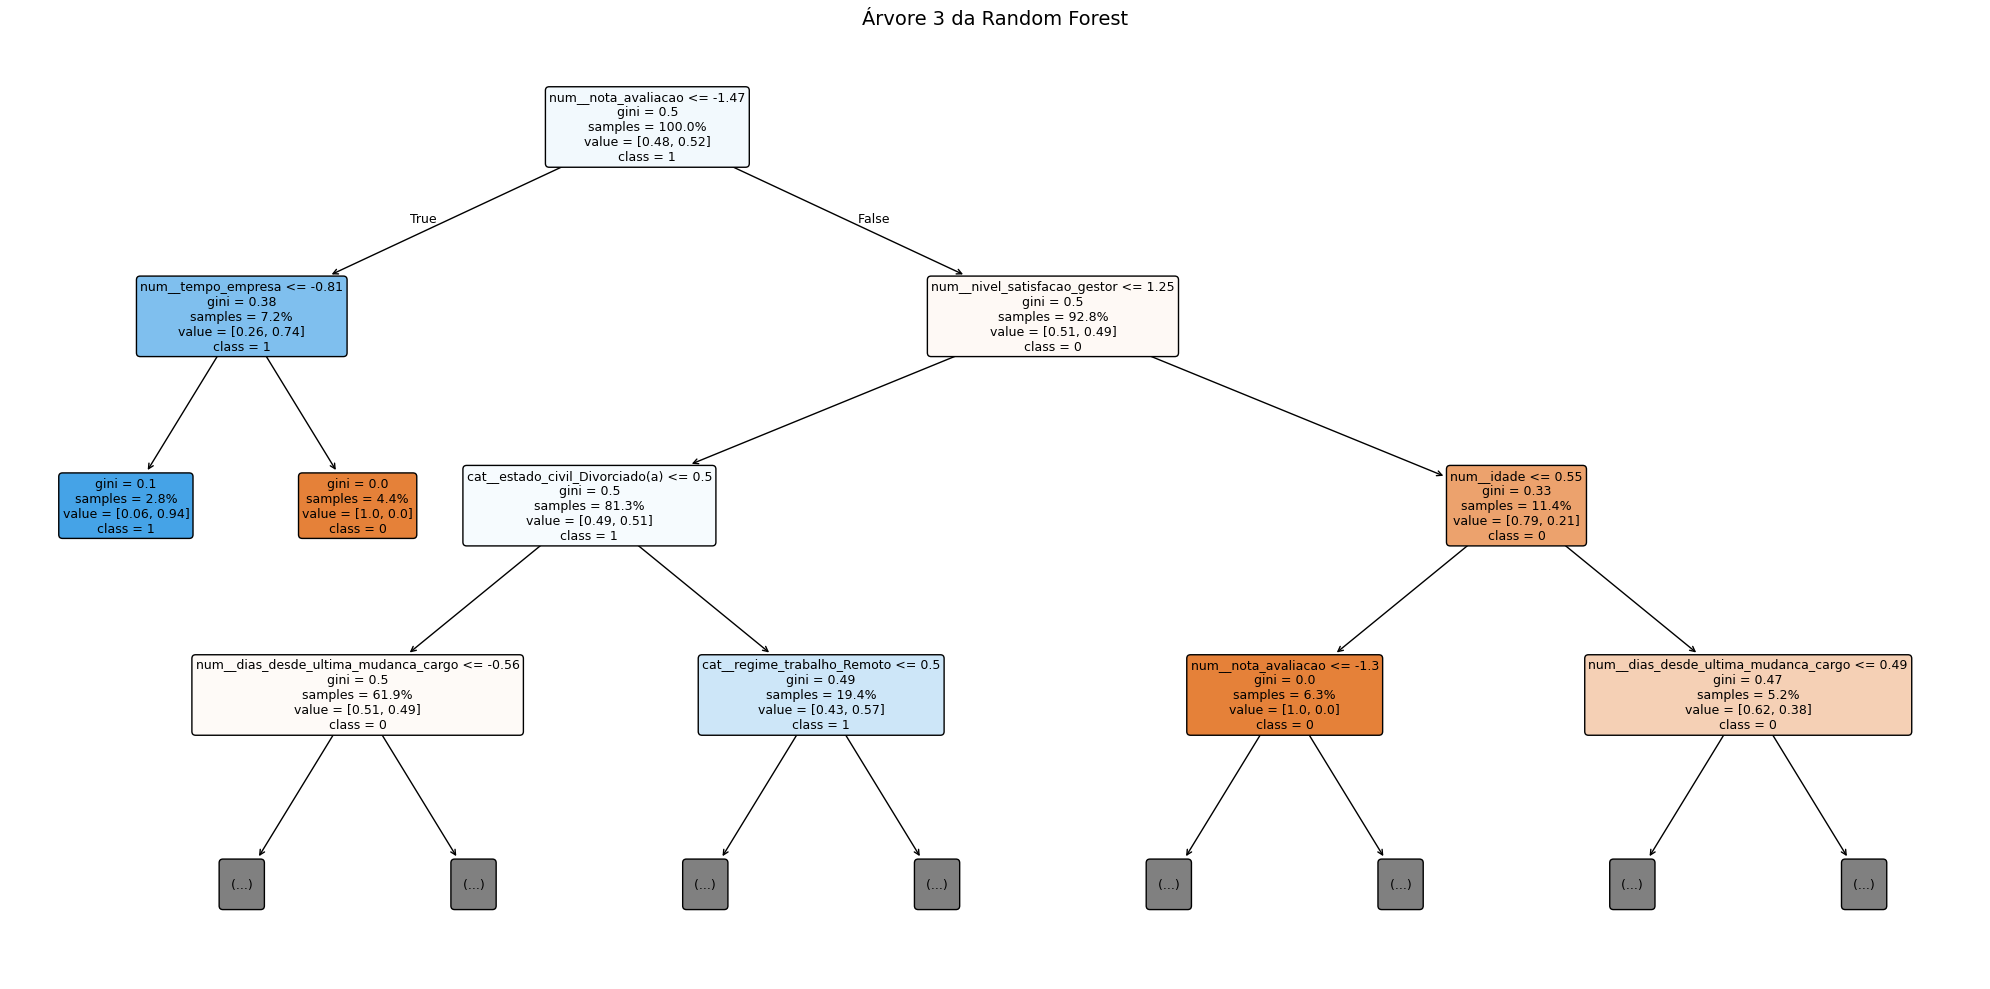

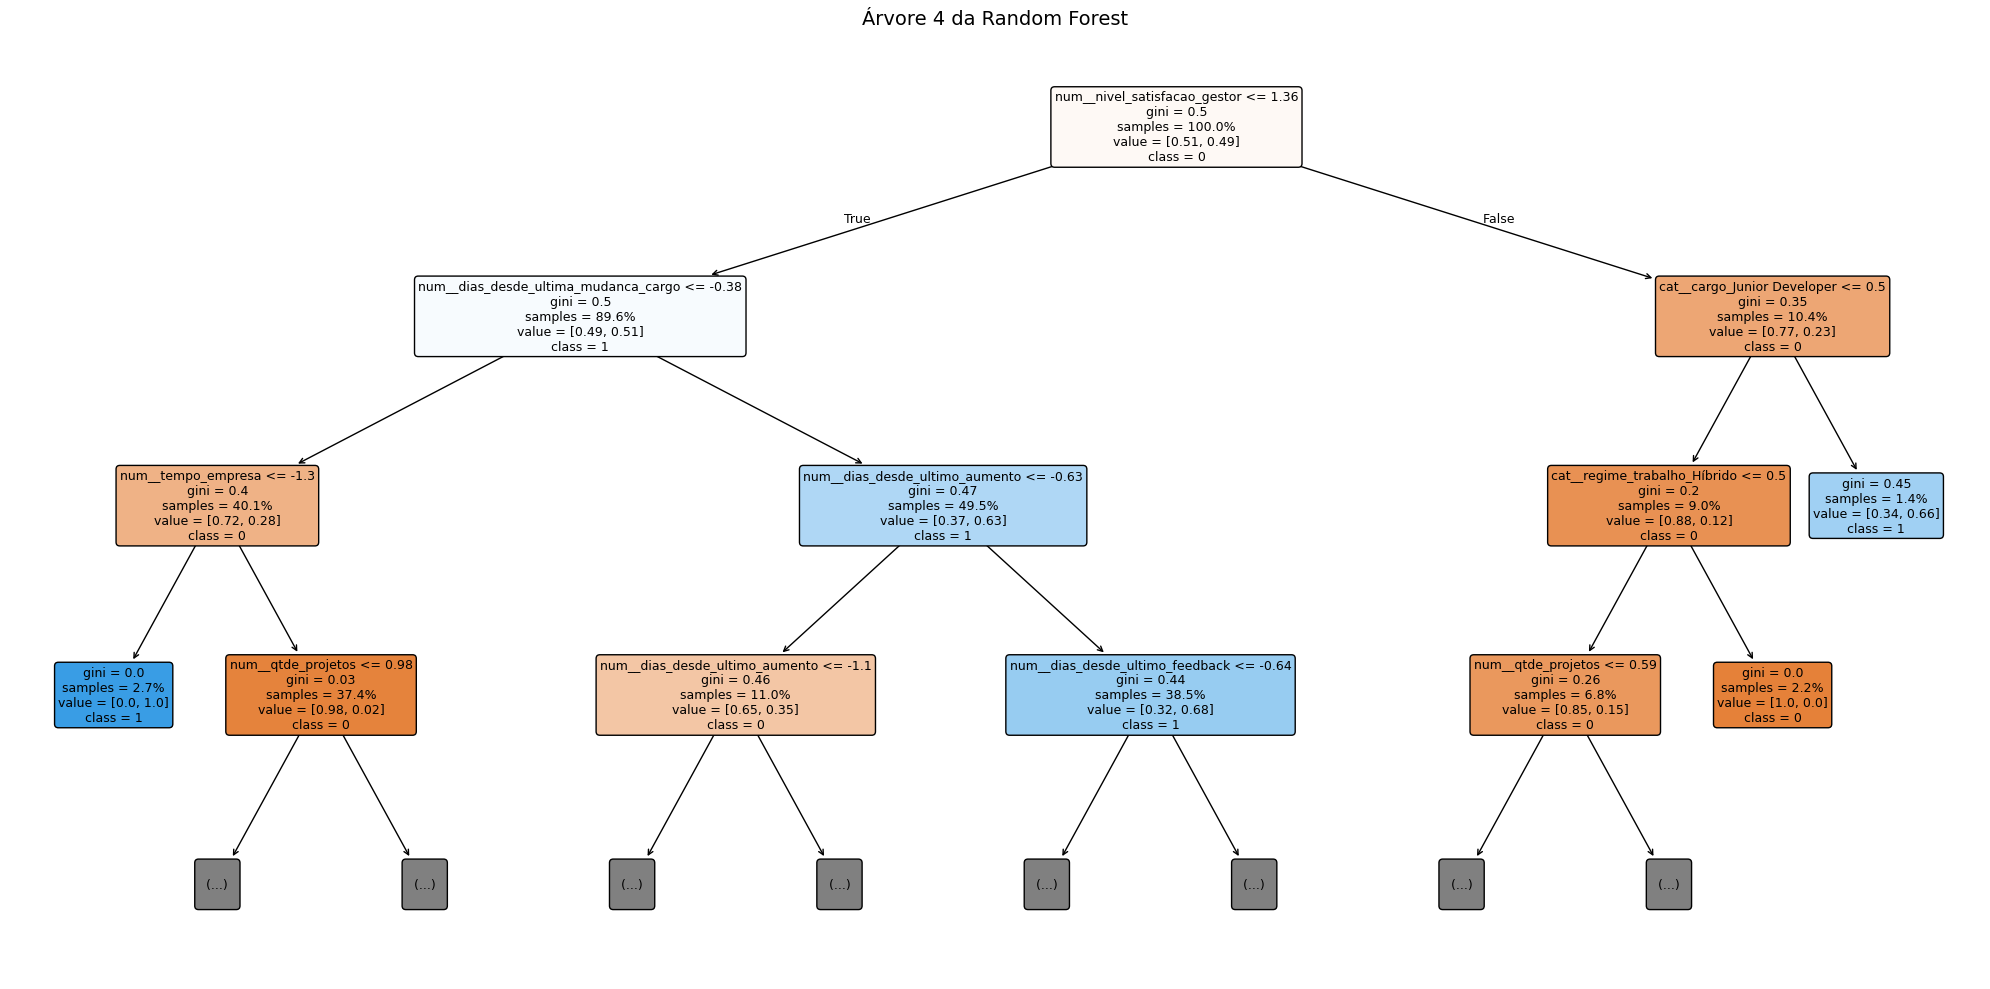

In [61]:
for i in range(5):
    visualizar_arvore(best_model,i,3)

## Apresentar Plots Shapley Values

In [62]:
# Rodar o explainer no conjunto de treinamento
explainer_class = shap.Explainer(best_model.predict, X_train, feature_names = nomes_features)

In [63]:
shap_values_class = explainer_class(X_test)

PermutationExplainer explainer: 1001it [02:35,  6.19it/s]                          


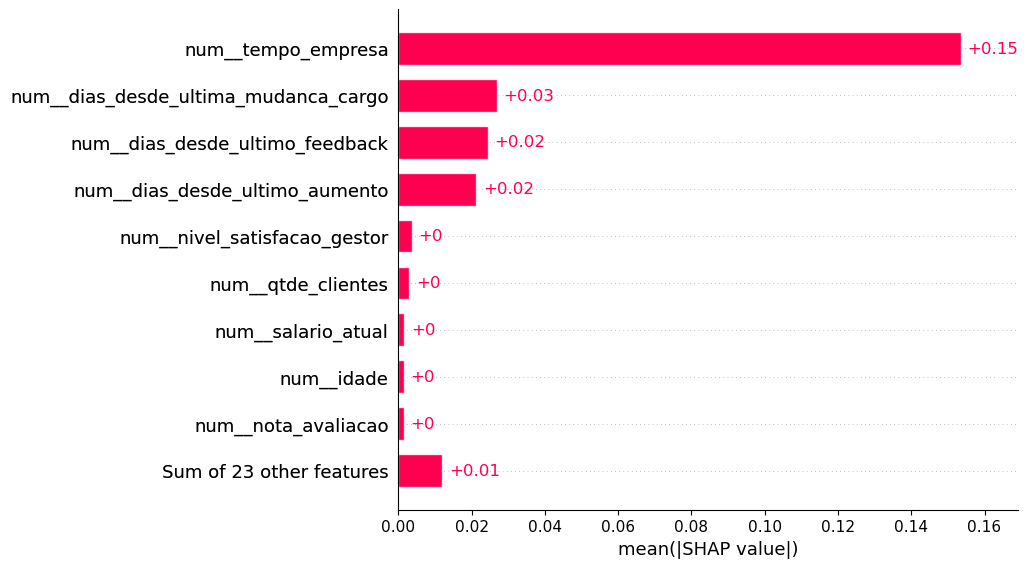

In [64]:
# Plotar a contribuição global por Shapley Values
shap.plots.bar(shap_values_class)

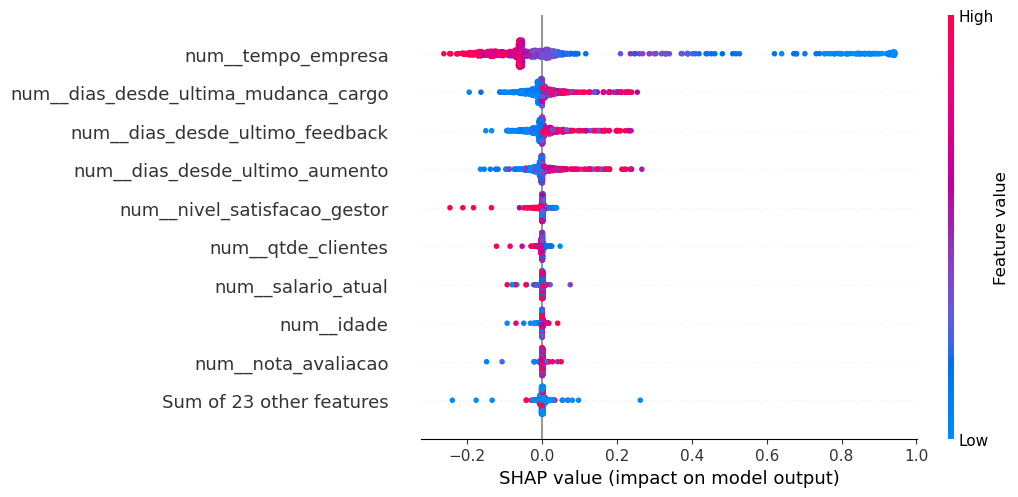

In [65]:
# Plot de Beeswarm Global
shap.plots.beeswarm(shap_values_class,max_display=10)

In [66]:
df_comparacao = pd.DataFrame({'y_test':y_test, 'y_pred':y_pred})

In [67]:
df_comparacao

,y_test,y_pred
1860,1,1
353,0,0
1333,0,0
905,1,1
1289,0,0
...,...,...
25,1,0
1858,0,0
714,0,0
1009,0,0


In [68]:
# Valor real (25)
y_test[25]

np.int64(1)

In [69]:
# Valor predito
y_pred[25]

np.int64(0)

In [70]:
# mostrar os dados do indice 25
X_test[25]

array([-0.80182424, -0.49298623,  0.60187347,  0.00468384, -0.02221185,
        0.30685116,  1.56267302,  1.27940306,  1.11526451,  0.10209731,
        0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
        1.        ,  1.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
        0.        ,  0.        ])

In [71]:
def invese_transform_manual(X_transformed, preprocessor, feature_names):

    # Armazenar os nomes originais das features
    features_names_original = feature_names

    # Criar um Dataframe com os dados transformados
    df_transformed = pd.DataFrame(X_transformed, columns=preprocessor.get_feature_names_out())

    # Criar um DataFrame vazio para receber os dados originais
    df_original = pd.DataFrame(columns=features_names_original)

    # Loop em cada transformador
    for name, transformer, features in preprocessor.transformers_:
        if name == 'num':
            # Para features numéricas, usar o inverse_transform
            df_original[features] = transformer.inverse_transform(
                df_transformed[[f'{name}__{f}' for f in features]]
            )
        elif name == 'cat':
            # Para features categóricas, precisamos identificar as colunas e qual delas tem o valor 1

            for feature in features:
                cols = [col for col in df_transformed.columns if col.startswith(f'{name}__{feature}')]

                for col in cols:
                    if df_transformed[col].iloc[0] == 1:
                        df_original[feature] = col.split('__')[-1]
                        break
    return df_original

In [72]:
# Trazer dados originais do index 25
invese_transform_manual(X_test[[25]], preprocessador,X.columns)

,idade,genero,estado_civil,educacao,regime_trabalho,cargo,salario_atual,nota_avaliacao,acompanhamento_psicologo,qtde_projetos,qtde_clientes,nivel_satisfacao_gestor,tempo_empresa,dias_desde_ultimo_feedback,dias_desde_ultimo_aumento,dias_desde_ultima_mudanca_cargo
0,30.0,genero_M,estado_civil_Viúvo(a),educacao_Technical Degree,regime_trabalho_Híbrido,cargo_QA Engineer,11771.0,8.7,NaN,5.0,4.0,6.3,2120.0,1437.0,1404.0,973.0


In [73]:
# Probabilidade do index 25
y_pred_proba[25]

array([0.88838508, 0.11161492])

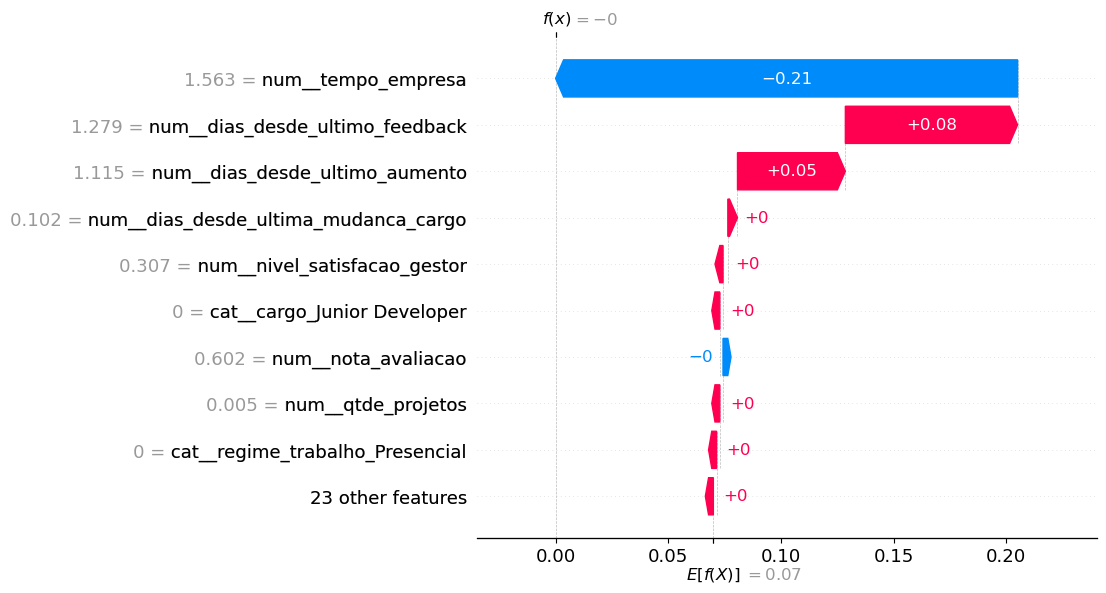

In [74]:
# Plotar os shap values para entender o que mais afetou nesse exemplo
shap.plots.waterfall(shap_values_class[25], max_display=10)